In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
import csv
sys.path.append('../python')
import plot_info
import numpy as np
import json



print(plot_info.get_git_metadata())


{'git_commit': '4addac37980ea21d98bf3df884eef35f54b187a5', 'git_repo_modified': 'False', 'git_branch': 'master', 'git_remote_url': 'git@github.com:kjetil-lye/alsvinn_metrics.git', 'git_short_commit': '4add'}


In [2]:

data_folder = '../data/runs_2019-02-22/'

basename_csv = os.path.join(data_folder, 'nx_{nx}/nx_{nx}.csv')
basename_report_profile = os.path.join(data_folder, 'nx_{nx}/alsuqcli_kh_report.json')
basename_report_large = os.path.join(data_folder, 'nx_large_{nx}/alsuqcli_kh_report.json')

# Nvidia P100 (https://www.nvidia.com/en-us/data-center/tesla-p100/)
max_bandwidth_gpu_gbs = 732
max_flops_gpu_gfs = 4.7*1000


In [3]:
def get_total_flops_and_memory(filename):
    with open(filename) as f:
        reader = csv.DictReader(f)
        flops = 0
        memory_read = 0
        memory_written = 0
        for row in reader:
             duration = float(row['Avg. Duration(ns)'])
             invocations = int(row['Invocations'])
             bandwidth_write = float(row['Device Memory Write Throughput(bytes/sec)'])
             bandwidth_read = float(row['Device Memory Read Throughput(bytes/sec)'])
             flops_dp_current = int(row['Floating Point Operations(Double Precision)'])
           
             flops += invocations * flops_dp_current
             
             memory_read += invocations*duration*bandwidth_read/10**9
             memory_written += invocations*duration*bandwidth_write/10**9
        return flops, memory_read, memory_written
            

In [4]:
def get_runtime(report_filename):
    with open(report_filename) as f:
        json_content = json.load(f)
        # reported in milliseconds
        return float(json_content['report']['wallTime'])/1000
    
def get_number_of_timesteps(report_filename):
        with open(report_filename) as f:
            json_content = json.load(f)
        
            
            return int(json_content['report']['timesteps'])

In [5]:
def get_flops_and_bandwidth_of_real_run(real_run_report, profile_run_report, profile_run_csv):
    flops, memory_read, memory_written = get_total_flops_and_memory(profile_run_csv)
    
    timesteps_profile = get_number_of_timesteps(profile_run_report)
    
    timesteps_real = get_number_of_timesteps(real_run_report)
    
    time_real = get_runtime(real_run_report)
    
    flops_real = ((flops*timesteps_real)/(timesteps_profile*time_real))
    
    memory_real = (((memory_read + memory_written)*timesteps_real)/(timesteps_profile*time_real))
    
    return flops_real, memory_real

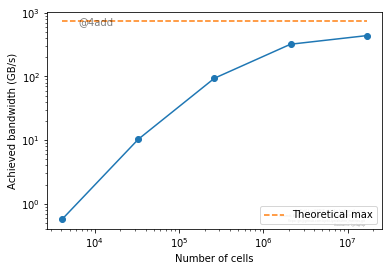

In [ ]:

nxs = 2**np.arange(4,9)

bandwidths_per_nx = []
flops_per_nx= []

for nx in nxs:
    csv_filename = basename_csv.format(nx=nx)
    report_profile = basename_report_profile.format(nx=nx)
    report_large = basename_report_large.format(nx=nx)
    
    flops, memory = get_flops_and_bandwidth_of_real_run(report_large, report_profile, csv_filename)
    
    bandwidths_per_nx.append(memory)
    flops_per_nx.append(flops)
bandwidths_per_nx = np.array(bandwidths_per_nx)
flops_per_nx = np.array(flops_per_nx)

plt.loglog(nxs**3, bandwidths_per_nx/10**9, '-o')
plt.plot([nxs[0]**3, nxs[-1]**3], [max_bandwidth_gpu_gbs, max_bandwidth_gpu_gbs], '--', label="Theoretical max")
plt.legend()

plt.xlabel("Number of cells")
plt.ylabel("Achieved bandwidth (GB/s)")
plot_info.showAndSave("bandwidth")


plt.semilogx(nxs**3, bandwidths_per_nx/10**9/max_bandwidth_gpu_gbs, '-o')

plt.grid(True)

plt.xlabel("Number of cells")
plt.ylabel("Achieved bandwidth (% of max)")
plot_info.set_percentage_ticks(plt.gca().yaxis)
plot_info.showAndSave("bandwidth_percent")



plt.loglog(nxs**3, flops_per_nx/10**9, '-o')
plt.plot([nxs[0]**3, nxs[-1]**3], [max_flops_gpu_gfs, max_flops_gpu_gfs], '--', label="Theoretical max")
plt.legend()

plt.xlabel("Number of cells")
plt.ylabel("Achieved Gflops (GF/s)")
plot_info.showAndSave("flops")


plt.semilogx(nxs**3, flops_per_nx/10**9/max_flops_gpu_gfs, '-o')

plt.grid(True)

plt.xlabel("Number of cells")
plt.ylabel("Achieved Gflops (% of max)")
plot_info.set_percentage_ticks(plt.gca().yaxis)
plot_info.showAndSave("flops_percent")

In [ ]:
print(bandwidths_per_nx)
print(flops_per_nx)

In [ ]:
print(bandwidths_per_nx/10**9)
print(flops_per_nx/10**9)